<a href="https://colab.research.google.com/github/hasanzaki/DeepLearning/blob/main/07_FFNN_CaliforniaHousing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [211]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch.nn.functional as F

In [212]:
# Step 1: Load the dataset

data = fetch_california_housing()
X, y = data.data, data.target # type: ignore

In [213]:
# Convert to DataFrame for visualization
df = pd.DataFrame(X, columns=data.feature_names) # type: ignore
df['Target'] = y

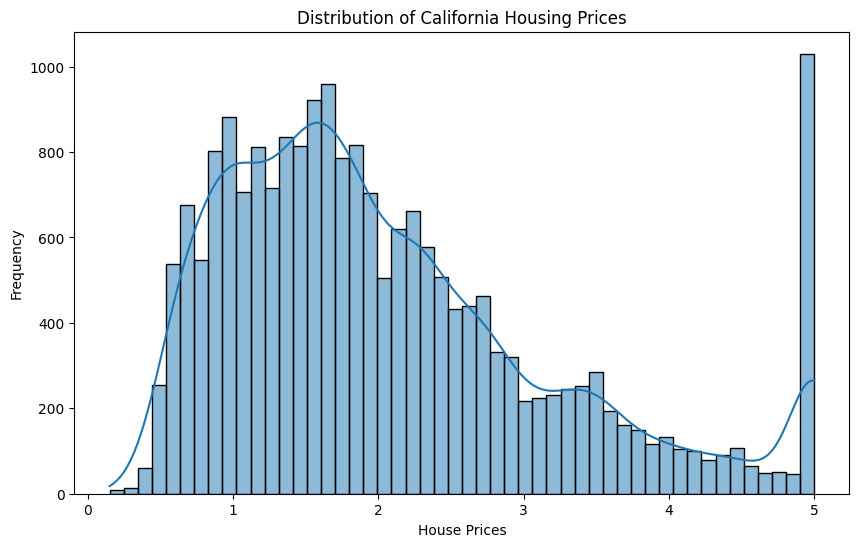

In [214]:
# Step 2: Visualize the dataset
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=50, kde=True)
plt.xlabel('House Prices')
plt.ylabel('Frequency')
plt.title('Distribution of California Housing Prices')
plt.show()

In [215]:
# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [216]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((16512, 8), (4128, 8), (16512,), (4128,))

In [217]:
# Step 4: Normalize the data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [218]:
print(X_train)

[[-0.326196    0.34849025 -0.17491646 ...  0.05137609 -1.3728112
   1.27258656]
 [-0.03584338  1.61811813 -0.40283542 ... -0.11736222 -0.87669601
   0.70916212]
 [ 0.14470145 -1.95271028  0.08821601 ... -0.03227969 -0.46014647
  -0.44760309]
 ...
 [-0.49697313  0.58654547 -0.60675918 ...  0.02030568 -0.75500738
   0.59946887]
 [ 0.96545045 -1.07984112  0.40217517 ...  0.00707608  0.90651045
  -1.18553953]
 [-0.68544764  1.85617335 -0.85144571 ... -0.08535429  0.99543676
  -1.41489815]]


In [219]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [220]:

class HousingNN(nn.Module):
    def __init__(self, in_features=8, h1=256, h2=128, h3=64, out_features=1):
        super(HousingNN, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.bn1 = nn.BatchNorm1d(h1)  # Batch normalization
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.fc3 = nn.Linear(h2, h3)
        self.bn3 = nn.BatchNorm1d(h3)
        self.fc4 = nn.Linear(h3, out_features)

        self.activation = nn.LeakyReLU(0.1)  # Helps avoid dead neurons
        self.dropout = nn.Dropout(0.2)  # Slightly lower dropout

    def forward(self, x):
        x = self.activation(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.activation(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.activation(self.bn3(self.fc3(x)))
        x = self.fc4(x)  # No activation for regression
        return x


In [221]:
# class HousingNN(nn.Module):
#     def __init__(self, in_features=8, h1=512, h2=256, h3=128, h4=64, out_features=1):
#         super(HousingNN, self).__init__()
#         self.fc1 = nn.Linear(in_features, h1)
#         self.bn1 = nn.BatchNorm1d(h1)
        
#         self.fc2 = nn.Linear(h1, h2)
#         self.bn2 = nn.BatchNorm1d(h2)
#         self.shortcut1 = nn.Linear(h1, h2)  # Projection layer

#         self.fc3 = nn.Linear(h2, h3)
#         self.bn3 = nn.BatchNorm1d(h3)
#         self.shortcut2 = nn.Linear(h2, h3)  # Projection layer

#         self.fc4 = nn.Linear(h3, h4)
#         self.bn4 = nn.BatchNorm1d(h4)
#         self.shortcut3 = nn.Linear(h3, h4)  # Projection layer

#         self.fc5 = nn.Linear(h4, out_features)  # Output layer

#         self.activation = nn.LeakyReLU(0.1)
#         self.dropout = nn.Dropout(0.15)  

#     def forward(self, x):
#         x = self.activation(self.bn1(self.fc1(x)))

#         x_res = self.shortcut1(x)  # Match dimensions
#         x = self.activation(self.bn2(self.fc2(x)) + x_res)  

#         x_res = self.shortcut2(x)
#         x = self.activation(self.bn3(self.fc3(x)) + x_res)  

#         x_res = self.shortcut3(x)
#         x = self.activation(self.bn4(self.fc4(x)) + x_res)  

#         x = self.fc5(x)  # No activation for regression
#         return x


In [222]:
# Step 6: Initialize model, loss, and optimizer

input_dim = X_train.shape[1]
model = HousingNN()

criterion = nn.MSELoss()           # Use this for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 

#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)



In [223]:
# #Step 6: Training the model

# epochs = 500 
# losses = []

# for i in range(epochs):
#     i+=1
#     y_pred = model(X_train)
#     loss = criterion(y_pred, y_train)
#     losses.append(loss)
    
#     # a neat trick to save screen space:
#     if i%10 == 1:
#         print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

#     optimizer.zero_grad() # zero the gradients before running the backward pass.
#     loss.backward()
#     optimizer.step() # update the weights

In [224]:
# Training Parameters


epochs = 500
patience = 20  # Early stopping patience
losses = []
val_losses = []  # Track validation loss
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(epochs):
    # === Training Step ===
    model.train()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # === Validation Step (No Gradients Needed) ===
    model.eval()
    with torch.no_grad():
        X_val, y_val = X_test, y_test  # Assign validation data
        y_val_pred = model(X_val)
        val_loss = criterion(y_val_pred, y_val).item()
        val_losses.append(val_loss)

    # Print progress every 5% of total epochs
    if epoch % (epochs // 20) == 0 or epoch == epochs - 1:
        print(f'Epoch [{epoch+1}/{epochs}] - Train Loss: {loss.item():.6f}, Val Loss: {val_loss:.6f}')

    # === Early Stopping ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  # Reset counter
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Stopping early at epoch {epoch+1}, best val loss: {best_val_loss:.6f}")
        break

Epoch [1/500] - Train Loss: 5.377960, Val Loss: 4.935930
Epoch [26/500] - Train Loss: 0.440667, Val Loss: 0.459896
Epoch [51/500] - Train Loss: 0.376998, Val Loss: 0.367444
Epoch [76/500] - Train Loss: 0.350734, Val Loss: 0.334810
Epoch [101/500] - Train Loss: 0.325241, Val Loss: 0.311881
Epoch [126/500] - Train Loss: 0.319238, Val Loss: 0.300618
Epoch [151/500] - Train Loss: 0.298591, Val Loss: 0.287659
Epoch [176/500] - Train Loss: 0.287978, Val Loss: 0.282515
Epoch [201/500] - Train Loss: 0.296889, Val Loss: 0.274736
Epoch [226/500] - Train Loss: 0.276009, Val Loss: 0.282900
Stopping early at epoch 249, best val loss: 0.269103


In [225]:
# Step 9: Evaluate the model

model.eval()
y_pred = model(X_test).detach().numpy()
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f'Test MSE: {test_mse:.4f}')


Test MSE: 0.2709


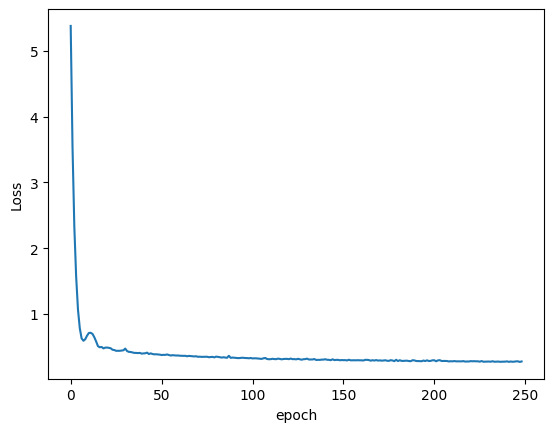

In [226]:
plt.plot(range(len(losses)), [loss for loss in losses])
plt.ylabel('Loss')
plt.xlabel('epoch');

In [227]:
# TO EVALUATE THE ENTIRE TEST SET

with torch.no_grad():
    y_val = model.forward(X_test)
    loss = criterion(y_val, y_test)
print(f'Mean Squared Error (MSE) on Test Set: {loss.item():.8f}')

Mean Squared Error (MSE) on Test Set: 0.27089903


In [228]:
correct = 0
threshold = 0.1  # Define a threshold for correctness (e.g., 10% of the actual value)

predictions = []
actuals = []

with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = model.forward(data.view(1, -1))
        predictions.append(y_val.item())
        actuals.append(y_test[i].item())
        
        # Check if the prediction is within the threshold
        if abs(y_val.item() - y_test[i].item()) <= threshold * abs(y_test[i].item()):
            correct += 1
        
        print(f'{i+1:2}. Predicted: {y_val.item():.4f}, Actual: {y_test[i].item():.4f}')

print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')

 1. Predicted: 0.4224, Actual: 0.4770
 2. Predicted: 0.9467, Actual: 0.4580
 3. Predicted: 4.4066, Actual: 5.0000
 4. Predicted: 2.4509, Actual: 2.1860
 5. Predicted: 2.5239, Actual: 2.7800
 6. Predicted: 1.5281, Actual: 1.5870
 7. Predicted: 2.4526, Actual: 1.9820
 8. Predicted: 1.7229, Actual: 1.5750
 9. Predicted: 2.4673, Actual: 3.4000
10. Predicted: 4.5890, Actual: 4.4660
11. Predicted: 0.9795, Actual: 1.2320
12. Predicted: 1.9487, Actual: 2.5390
13. Predicted: 1.5816, Actual: 2.1510
14. Predicted: 1.7412, Actual: 2.2050
15. Predicted: 2.5119, Actual: 2.1980
16. Predicted: 1.6687, Actual: 1.3620
17. Predicted: 1.9651, Actual: 1.7840
18. Predicted: 1.5356, Actual: 1.8750
19. Predicted: 1.7127, Actual: 1.3980
20. Predicted: 0.9568, Actual: 1.3750
21. Predicted: 4.1376, Actual: 4.2500
22. Predicted: 3.5971, Actual: 4.0560
23. Predicted: 1.2449, Actual: 1.3880
24. Predicted: 4.0652, Actual: 5.0000
25. Predicted: 1.6359, Actual: 1.6210
26. Predicted: 0.4752, Actual: 0.5140
27. Predicte